# Chapter 7. Ulysses' Compass

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import statsmodels.api as sm
import statsmodels.formula.api as smf

from patsy import dmatrix
from scipy import stats
from scipy.special import logsumexp

In [2]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
# az.rcParams["stats.hdi_prob"] = 0.89  # set credible interval for entire notebook
np.random.seed(0)

**Ockham's razor**: Models w/ fewer assumptions are to be preferred.
- It can be hard to use more generally, because usually we must choose among models that different in both their **accuracy** and their **simplicity**.

**Three fundamental kinds of statistical errors**:
1. Overfitting: matters for causal inference too
2. Underfitting
3. Confounding

This means, when we design any statical model, we must **decide whether we want to understand causes or rather just predict.**
- These are **not the same goal, and different models are needed for each.**

**Mitigating solutions for over-/under-fitting**: they can be (perhaps should be) used in combination.
1. **Regularizing prior**: same as *penalized likelihood* in non-Bayesian methods
2. **Information criteria** or **cross-validation**: estimate predictive accuracy
    - Need to understand *information theory*
    - Information criteria such as AIC, DIC, WAIC, PSIS, are easier to implement than understand; it's a curse!

**Rethinking: Stargazing**
- Stargazing: searching for a model where every coefficient is statistically significant
- **This model is not the best.**: p-values are *not designed to help you navigate between underfitting and overfitting*.

**Rethinking: Is AIC Bayesian?**
- AIC uses *MAP estimates instead of the entire posterior* and *requires flat priors*. (**BIC** is similar in this regard but it's **not actually an information criterion**.
- AIC is a special limit of a Bayesian criterion like WAIC. (Bayesian information criteria like WAIC provide almost exactly the same results as AIC, when AIC's assumptions are met.)
- AIC still has a clear and pragmatic interpretation un Bayesian probability. 

## 7.1. The problem with parameters

**Adding everything to the model is not okay.** The more parameters models have, the more likely they overfit. (Example: inflated $R^{2}$ score)

### 7.1.1. More parameters (almost) always improve fit.

##### Code 7.1: Brain and body mass data

In [3]:
brains = pd.DataFrame.from_dict(
    {
        "species": [
            "afarensis",
            "africanus",
            "habilis",
            "boisei",
            "rudolfensis",
            "ergaster",
            "sapiens",
        ],
        "brain": [438, 452, 612, 521, 752, 871, 1350],  # volume in cc
        "mass": [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5],  # mass in kg
    }
)

brains

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


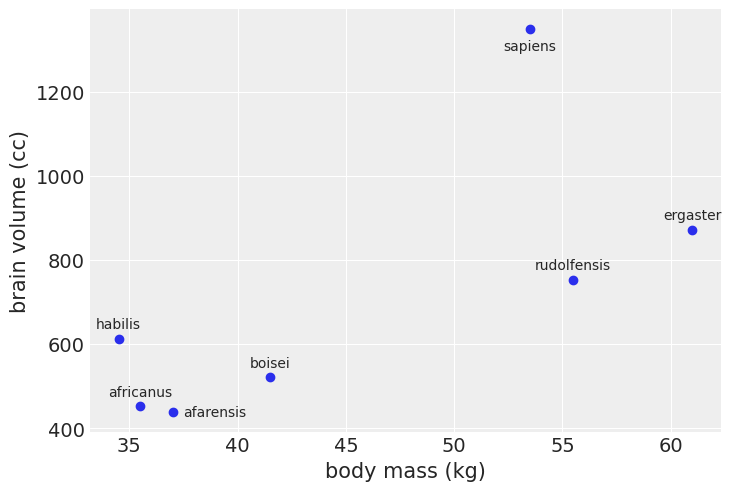

In [4]:
# Figure 7.2

plt.scatter(brains.mass, brains.brain)

# point labels
for i, r in brains.iterrows():
    if r.species == "afarensis":
        plt.text(r.mass + 0.5, r.brain, r.species, ha="left", va="center")
    elif r.species == "sapiens":
        plt.text(r.mass, r.brain - 25, r.species, ha="center", va="top")
    else:
        plt.text(r.mass, r.brain + 25, r.species, ha="center")

plt.xlabel("body mass (kg)")
plt.ylabel("brain volume (cc)");

##### Code 7.2: Standardize the data

In [5]:
brains.loc[:, "mass_std"] = (brains.loc[:, "mass"] - brains.loc[:, "mass"].mean()) / brains.loc[
    :, "mass"
].std()
brains.loc[:, "brain_std"] = brains.loc[:, "brain"] / brains.loc[:, "brain"].max()

##### Code 7.3

In [6]:
d = brains

In [7]:
with pm.Model() as m_7_1:
    
    a = pm.Normal("a", 0.5, 1)
    b = pm.Normal("b", 0, 10)
    sigma = pm.Lognormal("sigma", 0, 1)

    mu = a + b * d.mass_std    
    brain_std = pm.Normal("brain_std", mu=mu, sigma=sigma, observed=d.brain_std)
    
    m_7_1_trace = pm.sample()
    
az.summary(m_7_1_trace, round_to=2)

/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.53,0.10,0.36,0.74,0.0,0.0,1429.84,785.89,1.00
b,0.16,0.11,-0.04,0.37,0.0,0.0,1495.93,875.79,1.00
sigma,0.26,0.11,0.11,0.44,0.0,0.0,802.73,1113.70,1.01


The notebook exampels are a shorthand for the Bayesian models. They used OLS.

**Rethinking: OLS and Bayesian anti-essentialism**
- It's possible to use **ordinary least-squares (OLS)** to get posterior distributions.
- OLS is not considered a Bayesian algorithm. **But as long as the priors are vague**, minimizing the sum of squared deviations to the regression line is equivalent to finding the posterior mean.
- Like this, **in most cases, a non-Bayesian procedure will have an approximate Bayesian interpretation.**
    - **This is a good thing!**
    - **The Bayesian interpretation of a non-Bayesian procedure** recasts assumptions in terms of information, which is useful for understanding *why a procedure works*.
    - **A Bayesian model can be embodied in an efficient, but approximate, *non-Bayesian* procedure**. Bayesian inference is essentially about approximating the posterior distribution, and it doesn't specify how that approximation is done.

##### Code 7.3
This is modified from [Chapter 6 of 1st Edition](https://nbviewer.jupyter.org/github/pymc-devs/resources/blob/master/Rethinking/Chp_06.ipynb) (6.2 - 6.6).

In [8]:
m_7_1 = smf.ols("brain_std ~ mass_std", data=brains).fit()
m_7_1.summary()

/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              brain_std   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     4.807
Date:                Fri, 26 Mar 2021   Prob (F-statistic):             0.0798
Time:                        09:11:52   Log-Likelihood:                 2.9925
No. Observations:                   7   AIC:                            -1.985
Df Residuals:                       5   BIC:                            -2.093
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5287      0.071      7.492      0.001       0.347       0.710
mass_std       0.1671      0.076      2.192      0.080      -0.029       0.363
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.561
Prob(Omnibus):                    nan   Jarque-Bera (JB):                2.372
Skew:                           1.399   Prob(JB):                        0.305
Kurtosis:                       3.548   Cond. No.                         1.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Code 7.4

In [9]:
p, cov = np.polyfit(brains.loc[:, "mass_std"], brains.loc[:, "brain_std"], 1, cov=True)

post = stats.multivariate_normal(p, cov).rvs(1000)

az.summary({k: v for k, v in zip("ba", post.T)}, kind="stats")

,mean,sd,hdi_3%,hdi_97%
b,0.167,0.077,0.015,0.300
a,0.530,0.070,0.398,0.661


##### Code 7.5

In [10]:
1 - m_7_1.resid.var() / brains.brain_std.var()

0.49015804794908413

##### Code 7.6

In [11]:
def R2_is_bad(model):
    return 1 - model.resid.var() / brains.brain_std.var()


R2_is_bad(m_7_1)

0.49015804794908413

##### Code 7.7

In [12]:
m_7_2 = smf.ols("brain_std ~ mass_std + I(mass_std**2)", data=brains).fit()
m_7_2.summary()

/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              brain_std   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     2.310
Date:                Fri, 26 Mar 2021   Prob (F-statistic):              0.215
Time:                        09:11:53   Log-Likelihood:                 3.3223
No. Observations:                   7   AIC:                           -0.6445
Df Residuals:                       4   BIC:                           -0.8068
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.6142      0.155      3.950      0.017       0.182       1.046
mass_std             0.1957      0.093      2.101      0.104      -0.063       0.454
I(mass_std ** 2)    -0.0998      0.159     -0.629      0.564      -0.540       0.341
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.479
Prob(Omnibus):                    nan   Jarque-Bera (JB):                1.016
Skew:                           0.901   Prob(JB):                        0.602
Kurtosis:                       2.514   Cond. No.                         4.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Code 7.8

In [13]:
m_7_3 = smf.ols("brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3)", data=brains).fit()
m_7_4 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4)",
    data=brains,
).fit()
m_7_5 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4) + I(mass_std**5)",
    data=brains,
).fit()

##### Code 7.9

In [14]:
m_7_6 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4) + I(mass_std**5) + I(mass_std**6)",
    data=brains,
).fit()

##### Code 7.10

The chapter gives code to produce the first panel of Figure 7.3. Here, produce the entire figure by looping over models 7.1-7.6.

To sample the posterior predictive on a new independent variable we make use of theano SharedVariable objects, as outlined [here](https://docs.pymc.io/notebooks/data_container.html)

/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
<ipython-input-15-f3ddfe159409>:33: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


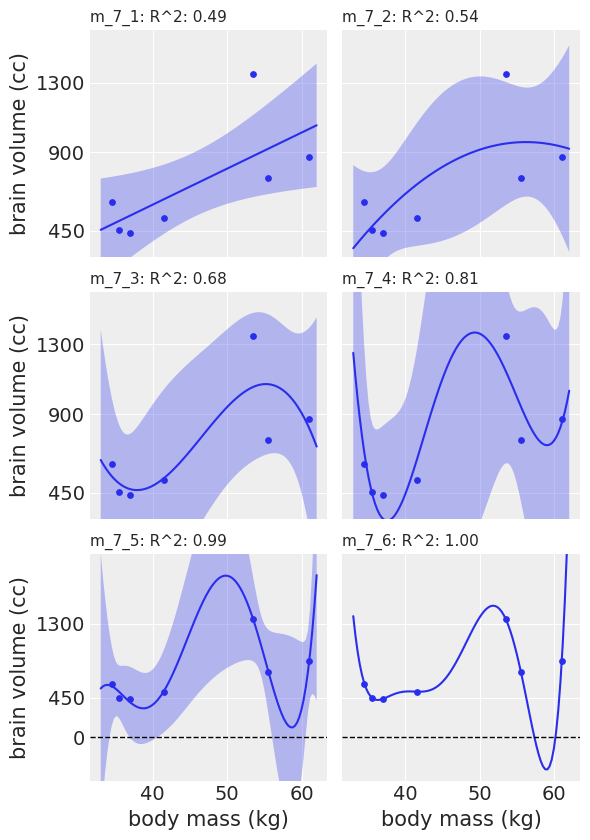

In [15]:
models = [m_7_1, m_7_2, m_7_3, m_7_4, m_7_5, m_7_6]
names = ["m_7_1", "m_7_2", "m_7_3", "m_7_4", "m_7_5", "m_7_6"]

mass_plot = np.linspace(33, 62, 100)
mass_new = (mass_plot - brains.mass.mean()) / brains.mass.std()

fig, axs = plt.subplots(3, 2, figsize=[6, 8.5], sharex=True, sharey="row")

for model, name, ax in zip(models, names, axs.flat):
    prediction = model.get_prediction({"mass_std": mass_new})
    pred = prediction.summary_frame(alpha=0.11) * brains.brain.max()

    ax.plot(mass_plot, pred["mean"])
    ax.fill_between(mass_plot, pred["mean_ci_lower"], pred["mean_ci_upper"], alpha=0.3)
    ax.scatter(brains.mass, brains.brain, color="C0", s=15)

    ax.set_title(f"{name}: R^2: {model.rsquared:.2f}", loc="left", fontsize=11)

    if ax.is_first_col():
        ax.set_ylabel("brain volume (cc)")

    if ax.is_last_row():
        ax.set_xlabel("body mass (kg)")

    if ax.is_last_row():
        ax.set_ylim(-500, 2100)
        ax.axhline(0, ls="dashed", c="k", lw=1)
        ax.set_yticks([0, 450, 1300])
    else:
        ax.set_ylim(300, 1600)
        ax.set_yticks([450, 900, 1300])

fig.tight_layout()

**Rethinking: Model fitting as compression**
- You can consider modeling fitting as a form of **data compression*.
- Overfitting means the data compression isn't really happening.
- Learning about the data requires using a simpler model that achieves some compression, but not too much.
- This view of model selection is known as **minimum description length (MDL)**.

##### Code 7.11 - this is R specific notation for dropping rows

In [16]:
brains_new = brains.drop(brains.index[-1])

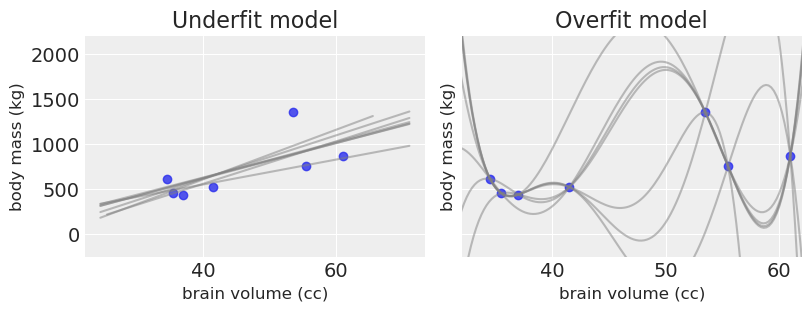

In [17]:
# Figure 7.4

# this code taken from PyMC3 port of Rethinking/Chp_06.ipynb

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 3))
ax1.scatter(brains.mass, brains.brain, alpha=0.8)
ax2.scatter(brains.mass, brains.brain, alpha=0.8)
for i in range(len(brains)):
    d_new = brains.drop(brains.index[-i])  # drop each data point in turn

    # first order model
    m0 = smf.ols("brain ~ mass", d_new).fit()
    # need to calculate regression line
    # need to add intercept term explicitly
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame(
        {"mass": np.linspace(x.mass.min() - 10, x.mass.max() + 10, 50)}
    )  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m0.predict(x_pred2)  # calculate predicted values
    ax1.plot(x_pred, y_pred, "gray", alpha=0.5)
    ax1.set_ylabel("body mass (kg)", fontsize=12)
    ax1.set_xlabel("brain volume (cc)", fontsize=12)
    ax1.set_title("Underfit model")

    # fifth order model
    m1 = smf.ols(
        "brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)", data=d_new
    ).fit()
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame(
        {"mass": np.linspace(x.mass.min() - 10, x.mass.max() + 10, 200)}
    )  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m1.predict(x_pred2)  # calculate predicted values from fitted model
    ax2.plot(x_pred, y_pred, "gray", alpha=0.5)
    ax2.set_xlim(32, 62)
    ax2.set_ylim(-250, 2200)
    ax2.set_ylabel("body mass (kg)", fontsize=12)
    ax2.set_xlabel("brain volume (cc)", fontsize=12)
    ax2.set_title("Overfit model")

**Rethinking:: Bias and variance**
- Bias-variance trade-off: essentially underfitting (too biased and can't predict well) and overfitting (prediction too variable)

## 7.2. Entropy and accuracy

We need to pick a criterion of model performance (=**target**). We're interested in *out-of-sample* deviance. How to do it:
1. We need to establish a measurement scale -> information theory
2. We need to establish *deviance* as an approximation of relative distance from perfect accuracy
3. We need to establish that it's only deviance *out-of-sample* that is of interest.

### 7.2.1. Firing the weatherperson
Accuracy depends on the definition of the target. Two things to consider:
1. Cost-benefit analysis
2. Accuracy in context

#### 7.2.1.2. Measuring accuracy
- Log scoring rule: log probability

### 7.3.2. Information and uncertainty
- We want to use the *log prob. of the data* to score the accuracy of competing models.
- Next question: how to measure distance from perfect prediction.

**Information theory**
- Deep connections to Bayesian inference
- Basic insight: *How much is our uncertainty reduced by learning an outcome?*
- The measured decrease in uncertainty = definition of information
    - *Informaiton*: the reduction in uncertainty when we learn an outcome

**Desiderata**
1. Should be continuous.
2. Should increase as the number of possible events increases.
3. Should be additive.

**Information entropy**
- Definition: *The uncertainty contained in a probability distribution is the **average log-probability of an event**.*
$$H(p) = -\text{E}\log(p_{i}) = - \sum_{i=1}^{n}p_{i}\log(p_{i})$$
- When $p_{i} = 0$ then entropy is also 0.

##### Code 7.12

In [18]:
p = np.array([0.3, 0.7])
-np.sum(p * np.log(p))

0.6108643020548935

**Rethinking: The benefit of maximizing uncertainty**
- *Maximum entropy (maxent)*: a family of techniques for including probability distributions that are most consistent with states of knowledge. In other words, **given what we know, what's the least surprising distribution?**.
- One way to answer this is to use the prior knowledge as contratin.
    - If we do this, we get the posterior distribution. 
    - Thus, **Bayesian updating is entropy maximization**.
- It's also useful for building GLMs.

### 7.2.3. From entropy to accuracy
Now we need to measure how far a model is from the target: **Divergence**
- *The additional uncertainty induced by using probabilities from one distribution to describe another distribution* = Kullback-Leibler divergence (KL divergence)

Divergence = **the average difference in log probability between the target (p) and the model (q)**.

$$D_{KL}(p, q) = \sum_{i}p_{i}(\log(p_{i}) - \log(q_{i})) = \sum_{i}p_{i}\log(\frac{p_{i}}{q_{i}})$$

- If q becomes more different from p, $D_{KL}$ also increases.
- Since predictive models specify probabilities of observations, we can use divergence to compare the accuracy of models.

**Cross entropy and divergence**
- When we use a probability distribution q to predict events from another distribution p, this defines cross entropy: $H(p, q) = -\sum_{i}p_{i}\log(q_{i})$
- Divergence is defined as *the additional entropy* induced by using q. Thus, it's the difference between $H(p)$, the actual entropy of events, and $H(p, q)$:
$$D_{KL}(p, q) = H(p, q) - H(p)$$

**Rethinking: Divergence depends upon direction**
- An important practical consequence of this asymmetry, in a model fitting context, is that *if we use a distribution with **high entropy** to approximate an unknown true distribution of events, we will **reduce the distance to the truth and therefore the error***.

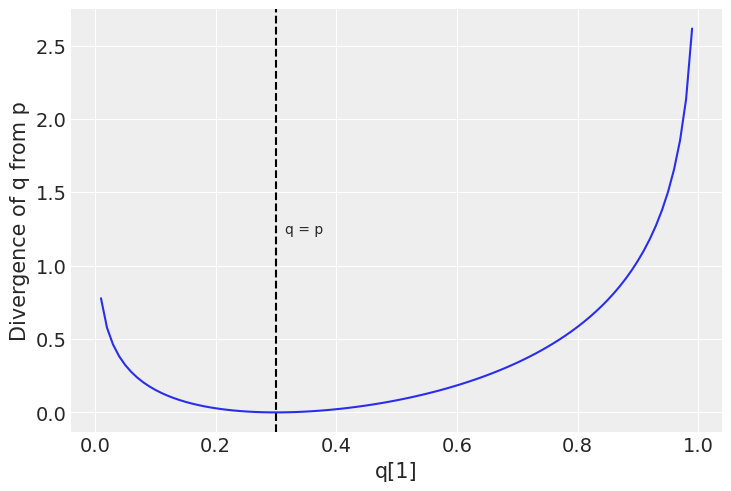

In [19]:
# Figure 7.5
p = np.array([0.3, 0.7])
q = np.arange(0.01, 1, 0.01)
DKL = np.sum(p * np.log(p / np.array([q, 1 - q]).T), 1)

plt.plot(q, DKL)
plt.xlabel("q[1]")
plt.ylabel("Divergence of q from p")
plt.axvline(0.3, ls="dashed", color="k")
plt.text(0.315, 1.22, "q = p");

### 7.2.4. Estimating divergence

To use $D_{KL}$, we need to know p. We can't know p. But it's okay because we can subtract p out. This also means that we just need to know the *model's average log-probability*: $E\log(q_{i})$. To pull this into practice, it's conventional to sum over all observations, yielding a total score for a model q:
$$S(q) = \sum_{i}\log(q_{i})$$

To compute this we need to use the *entire posterior distribution*. Otherwise, we will be throwing away information. **How can we use the entire distribution of predictions?**
- We need to find the log of the average probability for each observation where the average is taken over the posterior distribution. For some data $y$ and posterior distrubtion $\Theta$:

$$lppd(y, \Theta) = \sum_{i}\log \frac{1}{S} \sum_{s} p(y_{i}|\Theta_{s})$$

- lppd: Bayesian version of the log probability score.
    - Essentially, sum of the
        - log of the
            - average of posterior samples
    - **Essentially, the average log likelihood of the model (based on the posterior)**
- $S$: number of samples, $\Theta_{s}$: s-th set of sampled parameter values in the posterior distribution.
- Larger the better. (larger average accuracy)

**Deviance**: -2 x lppd

In [20]:
m_7_1.params

Intercept    0.528677
mass_std     0.167118
dtype: float64

##### Code 7.13 & 7.14: Computing log-pointwise predictive-density (LPPD)

In [21]:
n_samples = 3000

# sampling from multivariate normal distribution
# kinda hard to understand because m_7_1 is not a pymc3 model
intercept, slope = stats.multivariate_normal(m_7_1.params, m_7_1.cov_params()).rvs(n_samples).T
pred = intercept + slope * brains.mass_std.values.reshape(-1, 1)
n, ns = pred.shape

PyMC3 does not have a way to calculate LPPD directly, so we use the approach from 7.14. *But, pymc3's WAIC has lppd implementation in it (there's no direct method though)*.

In [22]:
# PyMC3 does not have a way to calculate LPPD directly, so we use the approach from 7.14

sigmas = (np.sum((pred - brains.brain_std.values.reshape(-1, 1)) ** 2, 0) / 7) ** 0.5
ll = np.zeros((n, ns))
for s in range(ns):
    logprob = stats.norm.logpdf(brains.brain_std, pred[:, s], sigmas[s])
    ll[:, s] = logprob

lppd = np.zeros(n)
for i in range(n):
    lppd[i] = logsumexp(ll[i]) - np.log(ns)

lppd

array([ 0.6142741 ,  0.65365724,  0.56090942,  0.62382269,  0.47779088,
        0.44813583, -0.85617862])

### 7.2.5. Scoring the right data
- The log-probability score has the same problem as $R^{2}$;  complex models return higher values.
- We can solve this by using test sample (this is also our interest).
- We need to compute train and test scores.

##### Code 7.15

In [23]:
# make an lppd function that can be applied to all models (from code above)
def lppd(model, n_samples=1e4):
    n_samples = int(n_samples)

    pars = stats.multivariate_normal(model.params, model.cov_params()).rvs(n_samples).T
    dmat = dmatrix(
        model.model.data.design_info, brains, return_type="dataframe"
    ).values  # get model design matrix
    pred = dmat.dot(pars)

    n, ns = pred.shape

    # this approach for calculating lppd isfrom 7.14
    sigmas = (np.sum((pred - brains.brain_std.values.reshape(-1, 1)) ** 2, 0) / 7) ** 0.5
    ll = np.zeros((n, ns))
    for s in range(ns):
        logprob = stats.norm.logpdf(brains.brain_std, pred[:, s], sigmas[s])
        ll[:, s] = logprob

    lppd = np.zeros(n)
    for i in range(n):
        lppd[i] = logsumexp(ll[i]) - np.log(ns)

    return lppd

In [24]:
# model 7_6 does not work with OLS because its covariance matrix is not finite.
lppds = np.array(list(map(lppd, models[:-1], [1000] * len(models[:-1]))))

lppds.sum(1)

array([ 2.54260289,  2.3218743 ,  2.89434267,  3.54488277, 10.9864629 ])

##### Code 7.16

This relies on the `sim.train.test` function in the `rethinking` package. [This](https://github.com/rmcelreath/rethinking/blob/master/R/sim_train_test.R) is the original function.

The python port of this function below is from [Rethinking/Chp_06](https://nbviewer.jupyter.org/github/pymc-devs/resources/blob/master/Rethinking/Chp_06.ipynb) Code 6.12.

In [25]:
def sim_train_test(N=20, k=3, rho=[0.15, -0.4], b_sigma=100):

    n_dim = 1 + len(rho)
    if n_dim < k:
        n_dim = k
    Rho = np.diag(np.ones(n_dim))
    Rho[0, 1:3:1] = rho
    i_lower = np.tril_indices(n_dim, -1)
    Rho[i_lower] = Rho.T[i_lower]

    x_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
    x_test = stats.multivariate_normal.rvs(cov=Rho, size=N)

    mm_train = np.ones((N, 1))

    np.concatenate([mm_train, x_train[:, 1:k]], axis=1)

    # Using pymc3

    with pm.Model() as m_sim:
        vec_V = pm.MvNormal(
            "vec_V",
            mu=0,
            cov=b_sigma * np.eye(n_dim),
            shape=(1, n_dim),
            testval=np.random.randn(1, n_dim) * 0.01,
        )
        mu = pm.Deterministic("mu", 0 + pm.math.dot(x_train, vec_V.T))
        y = pm.Normal("y", mu=mu, sd=1, observed=x_train[:, 0])

    with m_sim:
        trace_m_sim = pm.sample(return_inferencedata=True)

    vec = az.summary(trace_m_sim)["mean"][:n_dim]
    vec = np.array([i for i in vec]).reshape(n_dim, -1)

    dev_train = -2 * sum(stats.norm.logpdf(x_train, loc=np.matmul(x_train, vec), scale=1))

    mm_test = np.ones((N, 1))

    mm_test = np.concatenate([mm_test, x_test[:, 1 : k + 1]], axis=1)

    dev_test = -2 * sum(stats.norm.logpdf(x_test[:, 0], loc=np.matmul(mm_test, vec), scale=1))

    return np.mean(dev_train), np.mean(dev_test)

In [26]:
n = 20
tries = 10
param = 6
r = np.zeros(shape=(param - 1, 4))

train = []
test = []

for j in range(2, param + 1):
    print(j)
    for i in range(1, tries + 1):
        tr, te = sim_train_test(N=n, k=param)
        train.append(tr), test.append(te)
    r[j - 2, :] = (
        np.mean(train),
        np.std(train, ddof=1),
        np.mean(test),
        np.std(test, ddof=1),
    )

2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


Deviance is **an assessment of predictive accruacy, not of truth**.
- Deviance on training data **always improves** w/ additional predictor variables.
- Deviance on testing data may or may not, depending on
    1. True data-generating process
    2. How much data is available to precisely estimate the parameters.

##### Code 7.17

Does not apply because multi-threading is automatic in PyMC3.

##### Code 7.18

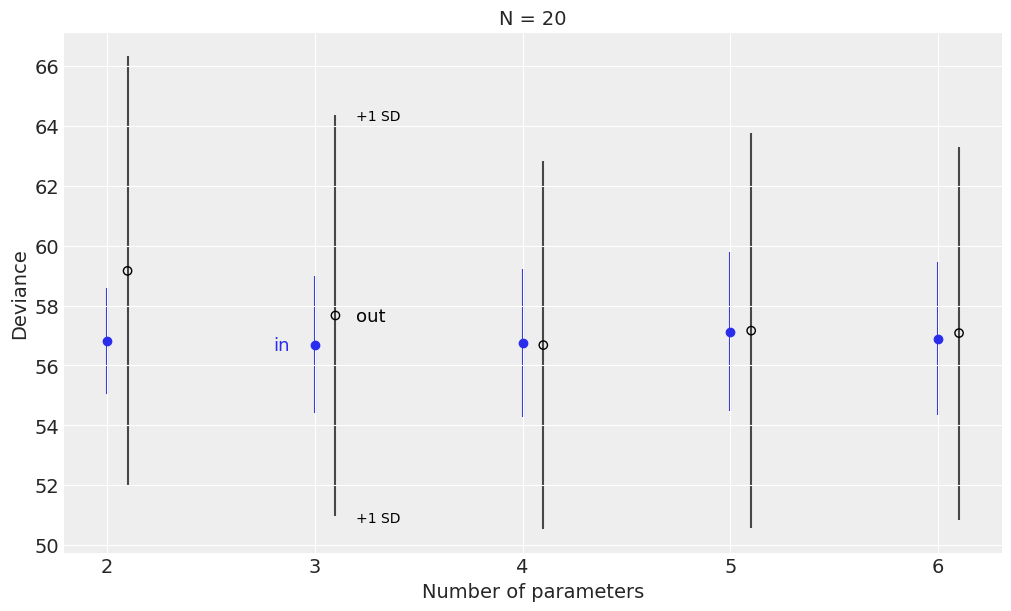

In [27]:
num_param = np.arange(2, param + 1)

plt.figure(figsize=(10, 6))
plt.scatter(num_param, r[:, 0], color="C0")
plt.xticks(num_param)

for j in range(param - 1):
    plt.vlines(
        num_param[j],
        r[j, 0] - r[j, 1],
        r[j, 0] + r[j, 1],
        color="mediumblue",
        zorder=-1,
        alpha=0.80,
    )

plt.scatter(num_param + 0.1, r[:, 2], facecolors="none", edgecolors="k")

for j in range(param - 1):
    plt.vlines(
        num_param[j] + 0.1,
        r[j, 2] - r[j, 3],
        r[j, 2] + r[j, 3],
        color="k",
        zorder=-2,
        alpha=0.70,
    )

dist = 0.20
plt.text(num_param[1] - dist, r[1, 0] - dist, "in", color="C0", fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] - dist, "out", color="k", fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] + r[1, 3] - dist, "+1 SD", color="k", fontsize=10)
plt.text(num_param[1] + dist, r[1, 2] - r[1, 3] - dist, "+1 SD", color="k", fontsize=10)
plt.xlabel("Number of parameters", fontsize=14)
plt.ylabel("Deviance", fontsize=14)
plt.title(f"N = {n}", fontsize=14)
plt.show()

These uncertainties are a *lot* larger than in the book... MCMC vs OLS again?

## 7.3. Golem taming: regularization

Regularization is about applying a *skeptical* prior (= prior that **slows the rate of learning**).
- **skeptical** prior = narrow prior
- Too strong (too narrow) -> underfitting

**Multilevel models**' central device is to **learn the strength of the prior from the data itself**.

**Rethinking: Ridge regression**
- Ridge regression: linear models where slope parameters use Gaussian priors centered at zero
- $\lambda$: essentially the narrowness of the prior; larger $\lambda$ -> less overfitting
- Another example of how a statistical procedure can be understood from both Bayesian and non-Bayesian perspectives.
- Ridge doesn't compute a posterior distribution.

## 7.4. Predicting predictive accuracy
We don't have the out-of-sample by definition, so then how? **cross-validation and information criteria**

### 7.4.1. Cross-validation
**How many folds?** Understudied question. Extremely common to use the max number of fold = **Leave-one-out cross-validation (LOOCV)**. Problem though; it taks too long.

Approximating the CV score w/o actually running the model over and over: use the **importance** of each observation to the posterior distribution
- **importance**: the impact of an observation on the posterior distribution (if we remove important ones, the posterior changes more)
- Key intution: *An observation that is relatively unlikely is MORE IMPORTANT than one that is relatively expected*. When expectations are violated, you should change your expectations more.

**Pareto-smoothed importance sampling cross-validation (PSIS)**
- Uses importance sampling and then Pareto-smoothing to make the importance weights more reliable
- Best feature: **It provides feedback about its own reliability** by noting particular observations with *very high weights* that could make the PSIS score inaccurate.
- Point-estimate: we can now compute standard error of the estimate of out-of-sample deviance.
- Standard error:
$$s_{\text{PSIS}}=\sqrt{N \text{var}(\text{psis}_{i})}$$



### Pareto-smoothed cross-validation

#### Cross-validation estimates the out-of-sample lppd
- With N observations, fit the model N times, dropping a single observation $y_{i}$ each time, then the out-of-sample lppd is the sum of the average accuracy for each ommitted $y_{i}$:
$$ \text{lppd}_{CV}= \sum_{i=1}^{N} \frac{1}{S} \sum_{s=1}^{S} \log \text{Pr}(y_{i}|\theta_{-i, s})$$
- $s$: indexes samples from a Markov chain
- $\theta_{-i, s}$: s-th sample from the posterior computed from observations ommiting $y_{i}$. 
- **Same as regular lppd but we just need a new distribution**

#### Going from the regular posterior to the one with leave-one-out (re-weighting)
Importance sampling replaces the computation of N posterior distributions by using an estimate of the importance of each i to the posterior distribution.

We draw samples from the full posterior distribution $p(\theta|y)$ but we want samples from the reduced leave-one-out posterior distribution $p(\theta|y_{-i})$. So we re-weight each sample $s$ by the inverse of the probability of the ommited observation:
$$r(\theta_{s}) = \frac{1}{p(y_{i}|\theta_{s})}$$

By applying this weight and normalizing, we get the **importance sampling (IS) estimate of out-of-sample lppd**:

$$ \text{lppd}_{IS}= \sum_{i=1}^{N} \log \frac
{\sum^{S}_{s=1}r(\theta_{s})p(y_{i}|\theta_{s})}
{\sum^{S}_{s=1}r(\theta_{s})}
$$


#### Applying the Pareto smoothing
The weights $r_{\theta_{s}}$ can be unreliable. If any $r_{\theta_{s}}$ is too relatively large, it can ruin the estimate of lppd by dominating it.

One strategy is to truncate the weights so that none are larger than a theoretically derived limit. This helps but it also biases the estimate. **PSIS** does this in a more clever way: it **exploits the fact that the distribution of weights should have a particular shape.**

**The *largest weights* should follow a generalized Pareto distribution**:
$$p(r|u, \sigma, k) = \sigma^{-1}(1+k(r-u)\sigma^{-1})^{-\frac{1}{k}-1}$$
- $u$: location parameter, $\sigma$: scale, $k$: shape
- For each observation $y_{i}$, the largest weights are used to estimate a Pareto distribution and then smoothed using that Pareto distribution. This **works well, both in theory and practice**.
- **The best thing about this approach**: $k$ eatimate provides information about the **reliability of the approximation**. 
    - There will be **one $k$ for each $y_{i}$**. **Larger $k$ means more influential points.**
    - If $k > 0.5$, the Pareto distribution has infinite variance (= very thick tail). Since we are trying to smooth the importance weights with the distribution's tail, **an infinite variance makes the weights harder to trust**. 
    - Still both theory and simulation suggest PSIS' weights perform well as long as $k < 0.7$.
- **Essentially, larger k means more influence but also if it's too large then it's unreliable.**

### 7.4.2. Information criteria
Information criteria **construct a theoretical estimate of the relative out-of-sample KL divergence**.

**Akaike information criterion (AIC)**
$$\text{AIC} = D_{train} + 2p = -2\text{lppd} + 2p$$
- $p$: the number of free parameters in the posterior distribution
- AIC tells us that the dimensionality of the posterior distribution is a natural measure of the model's overfitting tendency.
- AIC's approximation is **reliable only when**:
    1. The priors are flat or overwhelmed by the likelihood.
    2. The posterior distribution is approximately multivariate Gaussian.
    3. The sample size N is much grater than the number of parameters k.

**Deviance information criteria (DIC)**
- More general than AIC: okay with informative priors but still assumes that the posterior is multivariable Gaussian and that $N >> K$.

**Widely Applicable Information Criteria (WAIC)**
- Most general: no assumptions about the shape of the posterior
- Provides **an approximation of the out-of-sample deviance that converges to the cross-validation approximation in a large sample**. (In a finite sample, it can disagree)
- Formula:
$$\text{WAIC}(y, \Theta) = -2(\text{lppd} - \sum_{i}\text{var}_{\theta}\log p(y_{i}|\theta))$$
- $y$: observation, $\Theta$: posterior distribution
- Penalty term meaning: **"compute the variance in log-probabilities for each observation $i$, and then sum up these variances to get the total penalty"**
    - This means, **each observation has its own penalty score.** Meaning, you can assess **overfitting risk at the level of each observation.**
    - This penalty term is sometimes called **Effective Number of Parameters**, $p_{\text{WAIC}}$.
- WAICS is also **pointwise**.
    1. Like PSIS, we can **compute the standard error.**
    2. Some obervations have **stronger influence** on the posterior distribution, and WAIC notes this in its **pointwise penalty terms**.
    3. WAIC allows splitting up the data into independent observations (like CV and PSIS).

### Rethinking: Information criteria and consistency

Information criteria do not always assign the best expected $D_{test}$ to the *true* model (aka they are not **consistent** for model identification). This is for nominating models for **prediction based on out-of-sample deviance**.

They are not broken though. The consistency is normally evaluated **asymptotically (N approaching inifinity)**. With almost infinite data, CV, AIC, and WAIC all tend to choose more complex models.

### Rethinking: BIC & Bayes factors

The choice between BIC vs. AIC **is not about being Bayesian or not.** 
- **BIC** is related to the log of **the average likelihood** of a linear model. The average likelihood is **the denominator in Bayes' theorem, the likelihood average over the prior.** (There's venerable tradition in Bayesian inference of comparing average likelihoods in model comparison).
- **Bayes factor: the ratio of average likelihoods**. On the log scale, the ratios are differences, so similar to comparing differences in information criteria.

Many Bayesian statisticians dislike the Bayes factor approach because it's **difficult to compute average likelihood**. Also, **even when priors are weak and have little influence on posterior, priors can have a huge impact on comparisons between models**.

**The choice of Bayesian or not doesn't decide between information criteria or Bayes factors.** We can always use them both and learn from the ways they agree and disagree. Also remember, they know nothing about causation.

### Overthinking: WAIC calculation

##### Code 7.19: Construct a regression model

7.19 to 7.25 transcribed directly from 6.15-6.20 in [Chapter 6 of 1st Edition](https://nbviewer.jupyter.org/github/pymc-devs/resources/blob/master/Rethinking/Chp_06.ipynb).

In [28]:
data = pd.read_csv("Data/cars.csv", sep=",", index_col=0)

In [29]:
with pm.Model() as m:
    a = pm.Normal("a", mu=0, sd=100)
    b = pm.Normal("b", mu=0, sd=10)
    sigma = pm.Uniform("sigma", 0, 30)
    mu = pm.Deterministic("mu", a + b * data["speed"])
    dist = pm.Normal("dist", mu=mu, sd=sigma, observed=data["dist"])
    m = pm.sample(5000, tune=10000)

/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 10_000 tune and 5_000 draw iterations (20_000 + 10_000 draws total) took 29 seconds.


##### Code 7.20: Compute log likelihood of each observation $i$ at each sample $s$ from the posterior
Essentially, for each sample, we get the log probability (using `stats.norm.logpdf`); prob of obtaining the observation given the distribution (which is from a posterior sample).

In [30]:
n_samples = 1000
n_cases = data.shape[0]
logprob = np.zeros((n_cases, n_samples))

for s in range(0, n_samples):
    mu = m["a"][s] + m["b"][s] * data["speed"]
    p_ = stats.norm.logpdf(data["dist"], loc=mu, scale=m["sigma"][s])
    logprob[:, s] = p_

##### Code 7.21: Computing lppd (Bayesian deviance)
Average the samples in each row, take the log, and add all of the logs together. To do it accurately, we're doing this in the log scale. `logsumexp` computes **the log of a sum of exponentiated terms**.

In [31]:
n_cases = data.shape[0]
lppd = np.zeros(n_cases)
for a in range(1, n_cases):
    lppd[a] = logsumexp(logprob[a]) - np.log(n_samples)

In [32]:
lppd.shape

(50,)

We get lppd for every observation. The sum will be the lppd of all observations.

In [33]:
sum(lppd)

-202.89476541467073

##### Code 7.22: Computing $p_{\text{WAIC}}$ (penalty term)
Compute the variance across samples for each observation (we want to see how variable the posterior is given an observation, the higher more penalty), and sum.

In [34]:
pWAIC = np.zeros(n_cases)
for i in range(1, n_cases):
    pWAIC[i] = np.var(logprob[i])

##### Code 7.23: Compute WAIC

In [35]:
-2 * (sum(lppd) - sum(pWAIC))

412.84446027662256

##### Code 7.24: Compute the standard error

In [36]:
waic_vec = -2 * (lppd - pWAIC)
(n_cases * np.var(waic_vec)) ** 0.5

15.138168665819023

### 7.3.4. Comparing CV, PSIS, and WAIC
We need to compare **average out-of-sample scores** but also **average difference btw the out-of-sample deviance and each criterion.**

- PSIS and WAIC perform similarly for OLS models. If posterior is not approximately Gaussian or if poterior is influenced strongly by observations, then less likely.
- CV and PSIS have higher variance as estimators of the KL divergence, WAIC has greater bias.
- Watanabe recommends computing both WAIC and PSIS and contrasting them. **If there are large differences, this implies one or both criteria are unreliable.**
- PSIS's advantage: it can **warn the user about when it is unreliable via $k$ value**.

### Rethinking: Diverse prediction frameworks
- The distance between the models is useful, not the absolute value of deviance. 
- **Prequential** framework: models are judged on their **accumulated learning error over the training sample**.
- Multilevel models: "prediction" is *not uniquely* defined because the test sample can differ from the training sample in ways that forbid use of some of the parameter estimates. 
- A larger concern of train-test split: **uniformitarian assumption** (i.e. future data are expected to come from the same process as past data). You need science to solve this (over repeated rounds of model fitting, attempts at prediction, and model criticism...)

## 7.5. Model comparison

**Model selection**
Select the model with the lowest criterion value and discarding the others -> **NEVER DO THIS**.
- **Differences are useful.** Relative model accuracy provides advice about **how confident** we might be about models (conditional on the set of models compared).
- **Causal inference matters.** Maximizing expected predictive accuracy is not the same as inferring causation. **They don't tell us the consequences of an intervention.**

**Model comparison**
This is better! More general approach that uses multiple models to understand both **how different variables influence predictions** and in combination with a causal model, **implied conditinoal independencies among variables** help us infer causal relationships.

### 7.5.1. Model mis-selection
Predictive performance vs. causal inference

##### Setup for Code 7.25+

Have to reproduce m6.6-m6.8 from Code 6.13-6.17 in Chapter 6

In [37]:
# number of plants
N = 100
# simulate initial heights
h0 = np.random.normal(10, 2, N)
# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N / 2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)
# compose a clean data frame
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

with pm.Model() as m_6_6:
    p = pm.Lognormal("p", 0, 0.25)

    mu = pm.Deterministic("mu", p * d.h0)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_6_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_6_7:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)
    bf = pm.Normal("bf", 0, 0.5)

    p = a + bt * d.treatment + bf * d.fungus

    mu = pm.Deterministic("mu", p * d.h0)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_7_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_6_8:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)

    p = a + bt * d.treatment

    mu = pm.Deterministic("mu", p * d.h0)
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_8_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, p]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bf, bt, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.8810631131286413, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bt, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


#### Code 7.25: WAIC for m_6_7

In [38]:
az.waic(m_6_7_trace, m_6_7, scale="deviance")

/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:1406: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 by 100 log-likelihood matrix

              Estimate       SE
deviance_waic   346.76    14.83
p_waic            3.65        -

There has been a warning during the calculation. Please check the results.

#### Code 7.26

> `az.compare`: pseudo-Bayesian Model averaging using Akaike-type weighting, without Bootstrap stabilization (not recommended)

Default option is `stacking` which produces similar results as the book's (which basically anchors the performance with the best model's).

In [39]:
compare_df = az.compare(
    {
        "m_6_6": m_6_6_trace,
        "m_6_7": m_6_7_trace,
        "m_6_8": m_6_8_trace,
    },
#     method="pseudo-BMA",
    ic="waic",
    scale="deviance",
)
compare_df

/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:1406: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_6_7,0,346.758367,3.650576,0.000000,1.000000e+00,14.828924,0.000000,True,deviance
m_6_8,1,399.952512,2.678131,53.194145,0.000000e+00,13.132825,10.233728,False,deviance
m_6_6,2,423.958911,1.756911,77.200544,6.702860e-12,12.716223,12.166225,False,deviance


`d_waic`
- Differences between each mode's WAIC and the best WAIC. It's **difficult to know whether these differences are big or small by themselves**.
- Thus, we need to ask: **Are the models easily distinguished by their expected out-of-sample accuracy?** We need to consider the **error in the WAIC estimates**.

`se` and `dse`
- `se`: the approximate standard error of each WAIC. In a very approximate sense, we expect the uncertainty in out-of-sample accuracy to be normally distributed with mean equal to the reported WAIC and a standard deviation equal to the standard error. **When the sample is small, this approximation tends to dramatically underestimate the uncertainty.** Still better than AIC because it *doesn't provide uncertainty gauge* (because AIC can't be computed for individual data points).
- `dse`: **the standard error of their difference** (this is what we use **to distinguish the models**)


#### Code 7.27: Computing `dse` from WAIC values directly

In [40]:
waic_m_6_7 = az.waic(m_6_7_trace, pointwise=True, scale="deviance")
waic_m_6_8 = az.waic(m_6_8_trace, pointwise=True, scale="deviance")

# pointwise values are stored in the waic_i attribute.
diff_m_6_7_m_6_8 = waic_m_6_7.waic_i - waic_m_6_8.waic_i

n = len(diff_m_6_7_m_6_8)

print(np.sqrt(n * np.var(diff_m_6_7_m_6_8)).values)

10.233727736513952


/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:1406: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [41]:
print(compare_df.loc['m_6_8', 'dse'])

10.233727736513952


#### Code 7.28: 99% interval (z-score of about 2.6)

In [42]:
40.0 + np.array([-1, 1]) * compare_df.loc['m_6_8', 'dse'] * 2.6

array([13.39230789, 66.60769211])

#### Code 7.29: Visualizing the model comparison results
- Filled circles: in-sample deviance
- Open circles: WAIC values (out-of-sample) (usually worse than in-sample, which makes sense)
- Line segment: standard error of each WAIC
- **Triangle with line segment**: Difference in WAIC and standard error of the difference (<- **What we want**)
    - In the graph below, we can't distinguish the two models.

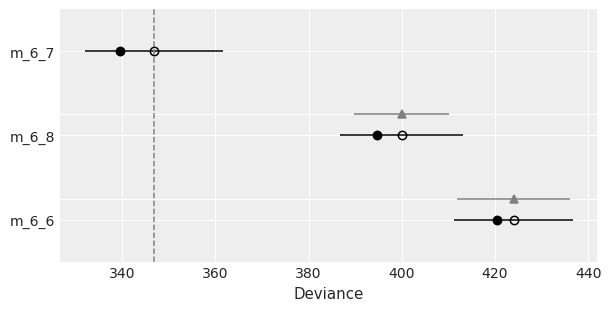

In [43]:
az.plot_compare(compare_df);

- This means **WAIC can't be used to infer causation** because we know that the treatment matters but the fungus can improve performance. WAIC can't show that (m_6_7, which has fungus did a better job according to WAIC).

#### Code 7.30: Comparing m_6_6 and m_6_8; are they distinguishable?

In [44]:
waic_m_6_6 = az.waic(m_6_6_trace, pointwise=True, scale="deviance")
diff_m6_6_m6_8 = waic_m_6_6.waic_i - waic_m_6_8.waic_i
n = len(diff_m6_6_m6_8)

print(np.sqrt(n * np.var(diff_m6_6_m6_8)).values)

10.197947332037154


#### Code 7.31

dSE is calculated by compare above, but `rethinking` produces a pairwise comparison. This is not implemented in `arviz`, but we can hack it together:

In [47]:
dataset_dict = {"m_6_6": m_6_6_trace, "m_6_7": m_6_7_trace, "m_6_8": m_6_8_trace}

# compare all models
s0 = az.compare(dataset_dict, ic="waic", scale="deviance")["dse"]
# the output compares each model to the 'best' model - i.e. two models are compared to one.
# to complete a pair-wise comparison we need to compare the remaining two models.

# to do this, remove the 'best' model from the input data
del dataset_dict[s0.index[0]]

# re-run compare with the remaining two models
s1 = az.compare(dataset_dict, ic="waic", scale="deviance")["dse"]

# s0 compares two models to one model, and s1 compares the remaining two models to each other
# now we just nee to wrangle them together!

# convert them both to dataframes, setting the name to the 'best' model in each `compare` output.
# (i.e. the name is the model that others are compared to)
df_0 = s0.to_frame(name=s0.index[0])
df_1 = s1.to_frame(name=s1.index[0])

# merge these dataframes to create a pairwise comparison
pd.merge(df_0, df_1, left_index=True, right_index=True)

/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:1406: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,m_6_7,m_6_8
m_6_8,10.233728,0.000000
m_6_6,12.166225,10.197947


**Note:** this work for three models, but will get increasingly hack-y with additional models. The function below can be applied to *n* models:

In [48]:
def pairwise_compare(dataset_dict, metric="dse", **kwargs):
    """
    Calculate pairwise comparison of models in dataset_dict.

    Parameters
    ----------
    dataset_dict : dict
        A dict containing two ore more {'name': pymc3.backends.base.MultiTrace}
        items.
    metric : str
        The name of the matric to be calculated. Can be any valid column output
        by `arviz.compare`. Note that this may change depending on the **kwargs
        that are specified.
    kwargs
        Arguments passed to `arviz.compare`
    """
    data_dict = dataset_dict.copy()
    dicts = []

    while len(data_dict) > 1:
        c = az.compare(data_dict, **kwargs)[metric]
        dicts.append(c.to_frame(name=c.index[0]))
        del data_dict[c.index[0]]

    return pd.concat(dicts, axis=1)

In [49]:
dataset_dict = {"m_6_6": m_6_6_trace, "m_6_7": m_6_7_trace, "m_6_8": m_6_8_trace}

pairwise_compare(dataset_dict, metric="dse", ic="waic", scale="deviance")

/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:1406: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,m_6_7,m_6_8
m_6_7,0.000000,NaN
m_6_8,10.233728,0.000000
m_6_6,12.166225,10.197947


**WAIC, CV, and PSIS guesses predictive accuracy but NOT causal truth**.

We need **posterior distributions of multiple models**, maybe examining the implied conditional independecies of a relevant causal graph to understand causal truth.

`weight` 

$$w_{i} = \frac{\exp(-0.5\Delta_{i})}{\sum_{j}\exp(-0.5\Delta_{j})}$$

- Relative support for each model, which sums to 1
- **Model averaging**: combining predictions of multiple models

### 7.5.2. Outlier and other illusions

Outliers tend to be very influential in OLS. We can use PSIS to detect outliers.

#### Code 7.32: Divorce model

In [50]:
d = pd.read_csv("Data/WaffleDivorce.csv", delimiter=";")

d["A"] = stats.zscore(d["MedianAgeMarriage"])
d["D"] = stats.zscore(d["Divorce"])
d["M"] = stats.zscore(d["Marriage"])

In [51]:
with pm.Model() as m_5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)

    mu = a + bA * d["A"]
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"])

    m_5_1_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bM * d["M"]
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"])

    m_5_2_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m_5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bA * d["A"] + bM * d["M"]
    sigma = pm.Exponential("sigma", 1)

    D = pm.Normal("D", mu, sigma, observed=d["D"])

    m_5_3_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, bA, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


#### Code 7.33: Comparing PSIS

`az.compare`'s `ic` argument can be used to set PSIS or WAIC (e.g., `ic="waic"`)

In [52]:
az.compare(
    {"m_5_1": m_5_1_trace, "m_5_2": m_5_2_trace, "m_5_3": m_5_3_trace},
    scale="deviance",
)

/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m_5_1,0,126.997216,3.768295,0.000000,0.892531,12.768613,0.000000,False,deviance
m_5_3,1,128.739934,4.808724,1.742718,0.000000,12.840961,0.706276,False,deviance
m_5_2,2,140.160198,2.854557,13.162982,0.107469,9.798477,9.271805,False,deviance


#### Code 7.34: Visualizing the pareto k and WAIC

/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:1406: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


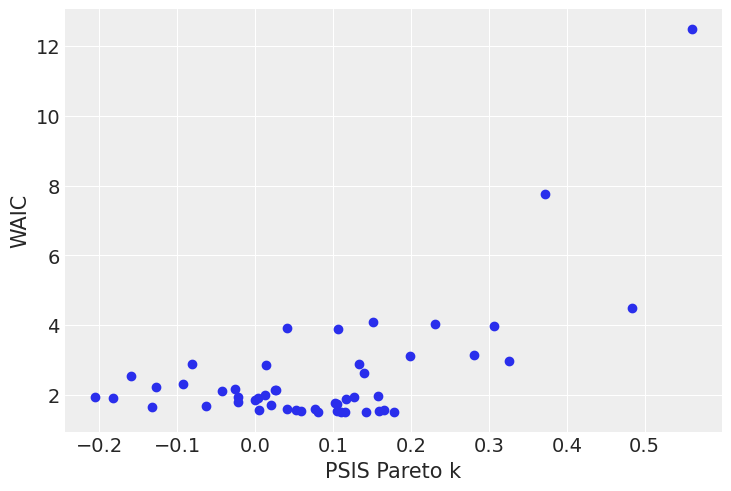

In [53]:
psis_m_5_3 = az.loo(m_5_3_trace, pointwise=True, scale="deviance")
waic_m_5_3 = az.waic(m_5_3_trace, pointwise=True, scale="deviance")

# Figure 7.10
plt.scatter(psis_m_5_3.pareto_k, waic_m_5_3.waic_i)
plt.xlabel("PSIS Pareto k")
plt.ylabel("WAIC");

**What should we do about outliers**
- Dropping outliers based on standard deviation: **NEVER DO THAT**
- **A point can only be unexpected and highly influential in light of a model.**
- A basic problem is that **the Gaussian error model is easily suprised**.

**Robust regression**
- Replacing the Gaussian model with a thicker-tailed sitribution like Student's T
- Requires additional $\nu$ parameter (shape parameter, which controls **the thickness of the tail**)
    - large $\nu$: tails are thin, $\infty$ means Gaussian.
- How to estimate $\nu$: Have a very large dataset with these events. (e.g., financial time series, taken over very long periods)
- But! with robust regression, we can't do this much because **there aren't many extreme obervations to fit $\nu$**. Thus, we assume that $\nu$ is very small (thick tails) in order to reduce the influence of outliers.

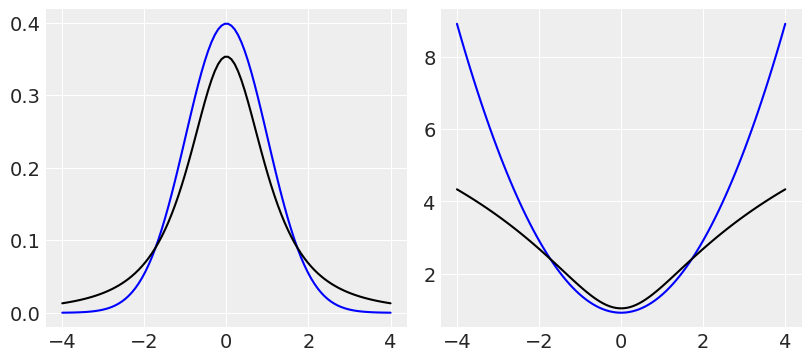

In [54]:
# Figure 7.11

v = np.linspace(-4, 4, 100)

g = stats.norm(loc=0, scale=1)
t = stats.t(df=2, loc=0, scale=1)

fig, (ax, lax) = plt.subplots(1, 2, figsize=[8, 3.5])

ax.plot(v, g.pdf(v), color="b")
ax.plot(v, t.pdf(v), color="k")

lax.plot(v, -g.logpdf(v), color="b")
lax.plot(v, -t.logpdf(v), color="k");

#### Code 7.35: Fitting the model w/ Student's t distribution

In [55]:
with pm.Model() as m_5_3t:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    mu = a + bA * d["A"] + bM * d["M"]
    sigma = pm.Exponential("sigma", 1)

    D = pm.StudentT("D", 2, mu, sigma, observed=d["D"])

    m_5_3t_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, bA, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


In [56]:
az.loo(m_5_3t_trace, pointwise=True, scale="deviance")

Computed from 2000 by 50 log-likelihood matrix

             Estimate       SE
deviance_loo   133.32    10.65
p_loo            5.37        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       50  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

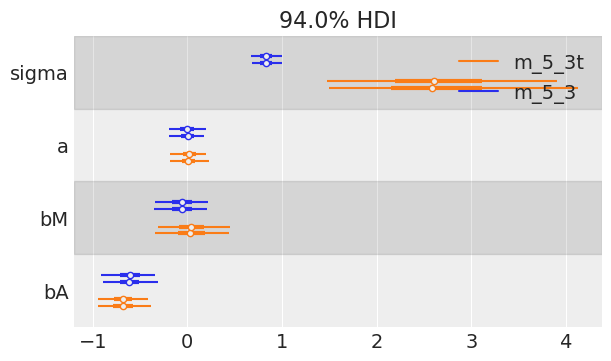

In [57]:
az.plot_forest([m_5_3_trace, m_5_3t_trace], model_names=["m_5_3", "m_5_3t"], figsize=[6, 3.5]);

### Rethinking: The Curse of Tippecanoe
One concern with model comparison; we might try all sorts of models and find a model that fits any sample very well. **But this will badly overfit, unlikely to generalize** (WAIC and other metrics can be fooled). 

However, **fitting many possible models isn't always a dangerous idea, provided some judgment is exercised in weeding down the list of variables at the start.** There are 2 scenarios where this strategy appears **defensible**.
1. Sometimes all one wants to do is explore a set of data, because there are no clear hypotheses to evaluate. (**Data dredging**, a pejorative term, when one doesn't admit to it). When used together with model averaging, and freely admitted, it can be a way to stimulate future investigation.
2. If we need to convince an audience that we've tried all of the combinations of predictors because none of the variables seem to help much in prediction.

## 7.6. Summary
- How to address overfitting
    1. Regularizing priors: reduce overfitting during estimation
    2. Estimates of out-of-sample accuracy (WAIC and PSIS): help estimate the degree of overfitting
- WAIC, PSIS, and CV can't help you if you want causal inference. (i.e., out-of-sample accuracy isn't for causal inference)
- Any causal estimate will still overfit the sample, so you need to still worry about overfitting and measuring it with WAIC/PSIS and reducing it with regularization.

In [58]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Fri Mar 26 2021

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.20.0

scipy      : 1.6.1
arviz      : 0.11.2
matplotlib : 3.3.4
pymc3      : 3.11.1
numpy      : 1.19.2
statsmodels: 0.12.2
pandas     : 1.2.2

Watermark: 2.2.0

